In [1]:
import requests
from selenium import webdriver
import math
import time
from webdriver_manager.chrome import ChromeDriverManager
import requests
from bs4 import BeautifulSoup
import numpy as np


# Функция преобразования номера тайла в координаты широты и долготы
def num2deg(xtile, ytile, zoom):
    n = 2.0 ** zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
    lat_deg = math.degrees(lat_rad)
    return (lon_deg, lat_deg)
# driver = webdriver.Chrome(ChromeDriverManager().install())

In [2]:
# Функция преобразования координаты широты и долготы d номера тайла 
import math
def deg2num(lon_deg, lat_deg, zoom):
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    return (xtile, ytile)

In [3]:
from copy import deepcopy
def getCorners(xtile, ytile, zoom):
    lu = num2deg(xtile, ytile, zoom)
    ru = (lu[0]+abs(lu[0]*2),lu[1])
    rd = (lu[0]+abs(lu[0]*2),lu[1]-lu[1]*2)
    ld = (lu[0],lu[1]-lu[1]*2)
    return (ld,rd,ru,lu)

In [4]:
getCorners(47,72,7)

((-47.8125, 21.943045533438177),
 (47.8125, 21.943045533438177),
 (47.8125, -21.943045533438177),
 (-47.8125, -21.943045533438177))

In [5]:
def pic_coord_to_lat_lon(x,y,z,xtile=0,ytile=0):
    left_cor= getCorners(xtile,ytile,z)[0]
    lo_l = left_cor[0]
    lo_sum = 2 * abs(lo_l)
    la_l = abs(left_cor[1])
    la_sum = 2 * abs(la_l)
    sootnoshenie_lo = x / 256
    sootnoshenie_la = y / 256
#     print(lo_l,la_l)
    lon = lo_l + lo_sum * sootnoshenie_lo
    lat = la_l - la_sum * sootnoshenie_la
    return lon,lat,z

In [6]:
pic_coord_to_lat_lon(51,96,7)
# deg2num(19.6875,-47.841259938641215,7)
# -108.28125, -21.262782194951654 19.6875, -47.841259938641215

(-108.28125, 21.262782194951654, 7)

In [7]:
def is_browser_open(driver):
    try:
        driver.window_handles
        return True
    except NoSuchWindowException:
        return False

In [8]:
def make_kml(name,corners):
    txt =f'''<?xml version="1.0" encoding="UTF-8"?>
        <kml xmlns="http://www.opengis.net/kml/2.2" xmlns:gx="http://www.google.com/kml/ext/2.2" xmlns:kml="http://www.opengis.net/kml/2.2" xmlns:atom="http://www.w3.org/2005/Atom">
        <GroundOverlay>
            <name>{name}</name>
            <Icon>
                <href>C:/Users/glebk/final_zone_image_sat/{name}.png</href>
                <viewBoundScale>0.75</viewBoundScale>
            </Icon>
            <gx:LatLonQuad>
                <coordinates>
                    {corners[0][0]},{corners[0][1]},0 {corners[1][0]},{corners[1][1]},0 {corners[2][0]},{corners[2][1]},0 {corners[3][0]},{corners[3][1]},0 
                </coordinates>
            </gx:LatLonQuad>
        </GroundOverlay>
        </kml>'''
    date = r'C:\Users\glebk\satbeams_kml' + '\\' + name + '.kml'
    with open(date,'w') as f:
        f.write(txt)

In [9]:
import json
with open('sat_zone.json') as f:
    sat_zones = json.loads(f.read())

In [10]:
# driver = open_browser()

In [11]:
def get_page_source(url='https://www.satbeams.com/footprints'):
#     driver = webdriver.Chrome(ChromeDriverManager().install())
    driver = webdriver.Chrome(ChromeDriverManager().install())
#     if is_browser_open(driver) == False:
#         driver = webdriver.Chrome(ChromeDriverManager().install())
    driver.get(url)#https://www.satbeams.com/footprints
#     driver.execute_script(f"window.location.href = {url}")
#     k = 2  
    # Maximize the window and let code stall 
    # for 10s to properly maximise the window.
    driver.maximize_window()
    time.sleep(1)

    # Obtain button by link text and click.
#     button = driver.find_element_by_css_selector("#map > div.leaflet-control-container > div.leaflet-top.leaflet-left > div.leaflet-control-zoom.leaflet-bar.leaflet-control > a.leaflet-control-zoom-in")
#     for i in range(zoom):
#         button.click()
#         time.sleep(3)

    # button.click()
    # time.sleep(3)
    # button.click()
    # time.sleep(3)
    page_source = driver.page_source
    driver.close()
    return page_source

In [12]:
# тут достаю сслыки на все спутники

# import requests
# from bs4 import BeautifulSoup
# import numpy as np
def get_sat_href():
    driver = webdriver.Chrome(ChromeDriverManager().install())
    driver.get('https://www.satbeams.com/footprints')
    page_source = driver.page_source
    soup = BeautifulSoup(page_source, 'html.parser')
    button_next = driver.find_element_by_css_selector('#sat_bar > div:nth-child(3)')
    links = soup.find_all('a', {'class':'sat_div satellite_gray'}, href=True)
    hrefs = np.array([])
    hr = np.array([])
    a = True
    while a == True:
        page_source = driver.page_source
        soup = BeautifulSoup(page_source, 'html.parser')
        # print(soup)    
        links = soup.find_all('a', {'class':'sat_div satellite_gray'}, href=True)
        for link in links:
            hr = np.append(hr,link.get('href'))
    #         hr.append(link.get('href'))
        if all(elem in hrefs for elem in hr):
            a = False
        else:
            result = np.in1d(hr, hrefs)
            hrefs = np.append(hrefs,hr[result==False])

        button_next.click()
        time.sleep(1)
#     driver.close()
    return hrefs
    # divs = soup.select('div.paint')

    # for div in divs:
    #     print(div.text)

In [10]:
hrefs = get_sat_href()

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache
D:\anaconda\envs\MLEnv\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [13]:
# driver = webdriver.Chrome(ChromeDriverManager().install())
# Здесь получаю сслыки на зоны покрытия по каждому спутнику

def get_zones_by_sat(hrefs):
    sats_and_zone = {}
    for href in hrefs:
        hrefs_zone = np.array([])
        hrefs_name = np.array([])
        print(href)
        page_s = get_page_source(url=f'https://www.satbeams.com/footprints{href}')
        soup = BeautifulSoup(page_s, 'html.parser')
        name_s = soup.find_all('td',{"colspan":'2'})[0].text
#         if name_s in sat_zones.keys():
#             continue
    #     print(soup)
        links_group_sat = soup.find_all('fieldset',{'class':'sat'})
        for sat in links_group_sat:
            if sat.find_all('div',{"id":'ext-comp-1002'}) != []:
                continue
            links = sat.find_all('a')
    #     print(links)
            for link in links:
        #         print(type(link.get('class')))
                if link.get('class') is not None:
                    if 'beam' in link.get('class'):
                        hrefs_zone = np.append(hrefs_zone,link.get('href'))
            names = sat.find_all('img',{'onerror':'noBeamImage(event, this);'})
            for n in names:
#                 print(n.get('src'))
                hrefs_name = np.append(hrefs_name,n.get('src').split('/')[3][:-7])
#                         hrefs_name = np.append(hrefs_name,link.get('class'))
#         for zone in hrefs_zone:
#             ps = get_page_source(url = f'https://www.satbeams.com/footprints{zone}')
#             if ps == 'Not Found':
#                 continue
#             s = BeautifulSoup(ps, 'html.parser')
#             if s.find_all('div',{"id":'ext-comp-1002'}) != []:
#                 continue
#             pic = s.find_all('img',{'role':'presentation'})
#             for p in pic:
#     #             print(p)
#                 href = p.get('src')
#                 if '.tile' not in href:
#                     hrefs_name = np.append(hrefs_name,href.split('/')[4])
#                     break
        sats_and_zone[name_s] = hrefs_name.tolist()
#         print(sats_and_zone)
    #                 print(link.get('href'))
    #     print(links)
    return sats_and_zone
#         print(sats_and_zone)
#         time.sleep(2)

In [117]:
sat_zones = get_zones_by_sat(hrefs)

?position=284



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=285



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=286



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=287



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=288



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=290



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=293



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=295



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=297



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=299



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=302



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=305



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=306



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=307



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=310



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=313



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=315



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=317



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=320



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=323



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=324



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=326



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=328



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=330



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=331



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=333



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=335



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=336



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=338



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=340



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=342



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=344



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=345



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=346



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=348



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=349



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=350



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=352



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=353



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=355



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=356



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=357



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=2



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=3



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=5



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=7



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=9



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=10



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=11



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=13



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=16



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=17



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=19



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=20



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=21



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=23



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=24



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=25



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=26



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=28



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=29



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=31



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=33



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=36



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=38



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=39



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=40



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=42



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=44



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=45



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=46



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=48



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=49



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=50



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=51



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=52



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=53



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=55



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=56



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=57



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=58



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=60



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=61



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=62



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=63



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=64



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=65



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=66



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=69



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=70



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=72



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=74



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=75



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=76



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=79



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=80



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=83



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=84



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=85



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=86



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=88



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=90



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=91



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=92



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=93



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=95



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=96



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=97



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=98



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=101



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=103



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=105



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=108



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=110



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=113



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=116



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=118



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=119



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=120



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=122



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=124



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=125



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=128



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=130



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=132



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=134



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=136



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=138



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=140



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=142



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=143



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=144



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=145



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=146



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=150



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=152



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=154



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=156



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=157



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=159



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=160



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=162



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=163



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=166



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=167



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=169



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=172



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=174



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=176



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=178



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=180



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=183



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=191



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=221



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=225



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=227



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=229



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=231



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=233



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=235



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=237



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=239



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=241



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=243



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=244



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=245



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=247



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=249



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=250



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=251



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=253



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=255



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=257



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=259



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=261



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=262



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=263



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=265



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=267



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=269



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=271



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=273



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=274



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=275



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=276



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=277



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=278



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=279



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=281



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


?position=283



[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 112.0.5615
[WDM] - Get LATEST chromedriver version for 112.0.5615 google-chrome
[WDM] - Driver [C:\Users\glebk\.wdm\drivers\chromedriver\win32\112.0.5615.49\chromedriver.exe] found in cache


In [14]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
def coord_contours(url,name,xtile=0,ytile=0,zoom=0):
#     print(url)
    response = requests.get(url) 
    with open(f'{name}.png', 'wb') as f:
                f.write(response.content)
    img = cv2.imread(f'{name}.png')
#     plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     plt.show()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     ret, thresh = cv2.threshold(gray, 127, 255, 0)
#     contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    f_x = 0
    f_y = 0
    f_w = 0
    f_h = 0
#     print(len(contours))
#     print(len(contours[2]))
    for cnt in contours:
#         print(cnt)
#         print(type(cnt))
        if len(cnt) == 256:
#             print(cnt)
            x,y,w,h = cv2.boundingRect(cnt)
            print(x,y,w,h)
            if w == 0 and h == 0:
                for i in range(2):
                    for j in range(2):
                        if requests.get(f'https://static.satbeams.com/tiles/{name}/1/{i}/{j}.png').status_code == 200:
                            print('exist')
                            return coord_contours(f'https://static.satbeams.com/tiles/{name}/1/{i}/{j}.png',name,xtile=i,ytile=j,zoom=1)
            else:
                f_x = x
                f_y = y
                f_w = w
                f_h = h
            # cv2_imshow(img)
                img = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                plt.show()
                return [f_x,f_y,f_w,f_h,zoom]
#             elif w > 8 and h > 8:
#                 f_x = x
#                 f_y = y
#                 f_w = w
#                 f_h = h
#             # cv2_imshow(img)
#                 img = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
#                 plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#                 plt.show()
#                 return f_x,f_y,f_w,f_h,zoom
#             elif len(contours) == 1:
#                 f_x = x
#                 f_y = y
#                 f_w = w
#                 f_h = h
#                 img = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
#                 plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#                 plt.show()
#                 return f_x,f_y,f_w,f_h,zoom
            
                
    # 142 89 45 49
    # img = cv2.rectangle(img,(142,89),(187,138),(0,255,0),2)
    # img = cv2.rectangle(img,(0,0),(240,240),(0,255,0),2)
#     plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     plt.show()
#     return f_x,f_y,f_w,f_h,zoom

76W-Ku-M2DL
https://static.satbeams.com/tiles/76W-Ku-M2DL/0/0/0.png
51 96 34 32


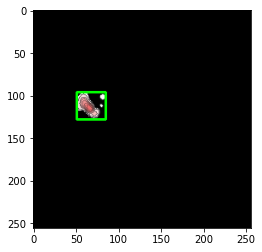

76W-Ku-MXK1H
https://static.satbeams.com/tiles/76W-Ku-MXK1H/0/0/0.png
19 77 58 39


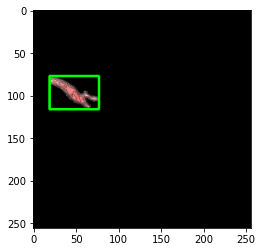

75W-Ku-ANDDH
https://static.satbeams.com/tiles/75W-Ku-ANDDH/0/0/0.png


KeyboardInterrupt: 

In [15]:
# получаем номера тайлов верхнего левого угла изображения и нижнего правого при зуме 7
zones_coord = {}
for sat in sat_zones.keys():
    for zone in sat_zones[sat]:
        print(zone)
        url = f'https://static.satbeams.com/tiles/{zone}/0/0/0.png'
        if requests.get(url).status_code == 200:
            print(url)
            contour = coord_contours(url,zone)
#             print(contour)
            tile_1 = pic_coord_to_lat_lon(contour[0],
                                          contour[1],
                                          contour[-1])
            tile_2 = pic_coord_to_lat_lon(contour[0]+contour[2],
                                          contour[1]+contour[3],
                                          contour[-1])
            tile_1 = deg2num(tile_1[0],tile_1[1],7)
            tile_2 = deg2num(tile_2[0],tile_2[1],7)
            zones_coord[zone] = [tile_1,tile_2]
#             print(coord_contours(url,zone))
#         print(zones_coord)
# sat_zones

In [15]:
# requests.get('https://static.satbeams.com/tiles/73W-Ku-Canada/1/0/0.png')
# coord_contours('https://static.satbeams.com/tiles/75W-Ku-ANDDV/0/0/0.png','75W-Ku-ANDDV')
with open('zones_coord.json') as f:
    zones_coord = json.loads(f.read())

In [120]:
import json
with open('sat_zone.json', 'w') as f:
    json.dump(sat_zones, f)

In [52]:
with open('zones_coord.json', 'w') as f:
    json.dump(zones_coord, f)

In [16]:
zones_coord

{'76W-Ku-M2DL': [[25, 56], [42, 64]],
 '76W-Ku-MXK1H': [[9, 51], [38, 61]],
 '75W-Ku-ANDDH': [[23, 51], [66, 80]],
 '75W-Ku-ANDDV': [[22, 51], [59, 81]],
 '75W-Ku-BRADH': [[32, 60], [66, 78]],
 '75W-Ku-BRADV': [[32, 60], [66, 84]],
 '75W-C-3': [[33, 61], [58, 77]],
 '75W-Ka-Spot01': [[51, 64], [53, 64]],
 '75W-Ka-Spot02': [[48, 64], [49, 64]],
 '75W-Ka-Spot03': [[49, 64], [50, 65]],
 '75W-Ka-Spot04': [[50, 64], [52, 65]],
 '75W-Ka-Spot05': [[47, 64], [48, 64]],
 '75W-Ka-Spot06': [[47, 64], [49, 65]],
 '75W-Ka-Spot07': [[49, 64], [50, 65]],
 '75W-Ka-Spot08': [[50, 65], [52, 65]],
 '75W-Ka-Spot09': [[47, 64], [49, 65]],
 '75W-Ka-Spot10': [[48, 65], [50, 65]],
 '75W-Ka-Spot11': [[49, 65], [51, 66]],
 '75W-Ka-Spot12': [[46, 65], [48, 65]],
 '75W-Ka-Spot13': [[47, 65], [49, 66]],
 '75W-Ka-Spot14': [[48, 65], [50, 66]],
 '75W-Ka-Spot15': [[49, 65], [51, 66]],
 '75W-Ka-Spot16': [[47, 65], [49, 66]],
 '75W-Ka-Spot17': [[48, 66], [50, 66]],
 '75W-Ka-Spot18': [[50, 66], [52, 67]],
 '75W-Ka-Spot1

In [21]:
import cv2
import numpy as np
# from google.colab.patches import cv2_imshow
# xy = []
# sat_photo_zone
def get_granica(name,x_tile_1,x_tile_2,y_tile_1,y_tile_2):
    xy = {}
    n = {}
    for j in range(y_tile_1,y_tile_2+1):
        for i in range(x_tile_1,x_tile_2+1):
            response = requests.get(f'https://static.satbeams.com/tiles/{name}/7/{i}/{j}.png')
#             print(response.status_code)
            if response.status_code != 200:
                continue
#             print(i,j)
            with open(f'sat_photo_zone/{name}.png', 'wb') as f:
                        f.write(response.content)
        #     img = cv2.imread(f'{name}.png')
            image = cv2.imread(f'sat_photo_zone/{name}.png')
#             cv2.imshow('image',image)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            edges = cv2.Canny(gray, 50, 150)
            num = 0
            contours = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#             print(len(contours))
#             print(11111111111111111111111111111111111111111111111111111111111)
#             print(contours)
#             print(len(contours))
            if contours == []:
                continue
            p = contours[1]
            for contour in p:
#                 contour = contours[p][0]
#                 print(len(contour))
#                 print('contour')
#                 print(contour)
                if len(contour) > 40:
#                     xy[f'{i}_{j}_{num}'] = []
                    n[num] = []
                    num += 1
#                     print('new contour')
                    for point in contour:
#                         print('point')
#                         print(point)
                        x,y = point[0]
                        # print(x,y)
#                         xy[f'{i}_{j}_{num-1}'].append([x,y])
                        n[num-1].append([x,y])
                          # xy.append([x,y])
                        cv2.circle(image,(x,y),1,(0,255,0),-1)
#             print(n.keys())
            if n.keys() == []:
                continue
            xy[f'{i}_{j}'] = n.copy()
            n.clear()
            for k in xy.keys():
#                 print(xy[k].keys())
                for l in xy[k].keys():
                    xy[k][l] = sorted(xy[k][l])
#             print(xy.keys())
            cv2.circle(image,(0,80),1,(0,0,255),-1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.show()
    return xy
#             cv2.imshow('ed',edges)
#             cv2.imshow('im',image)
#             cv2.waitKey(0)
#             cv2.destroyAllWindows()

76W-Ku-M2DL
25 56 42 64


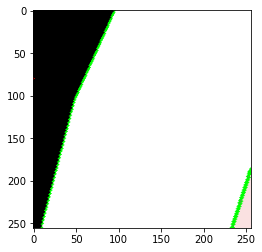

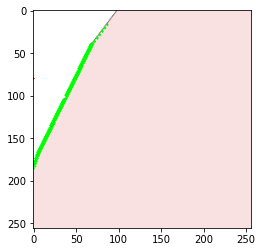

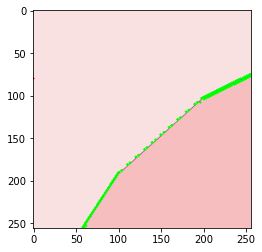

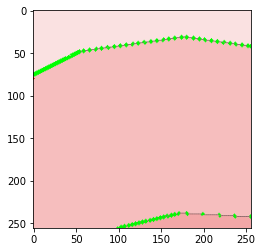

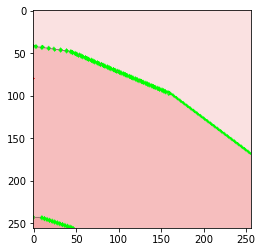

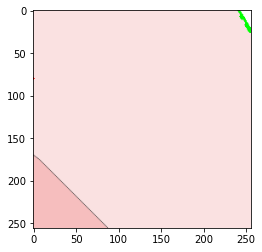

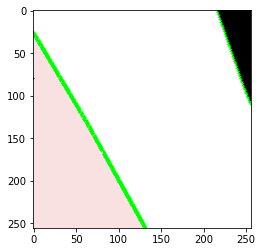

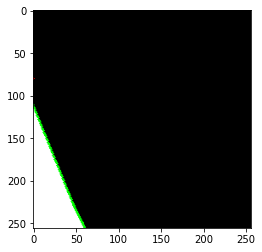

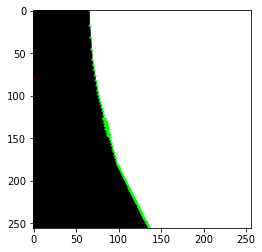

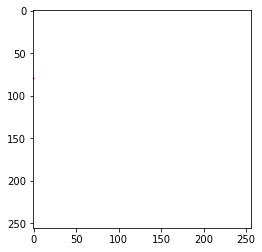

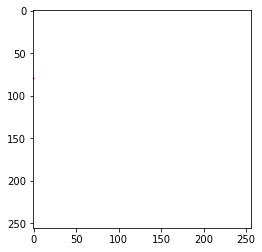

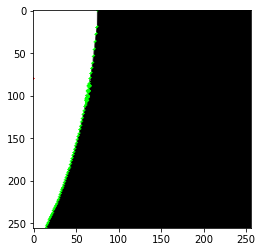

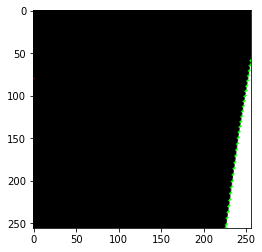

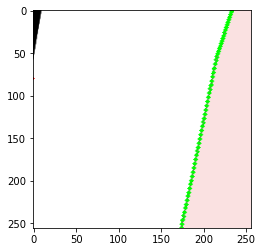

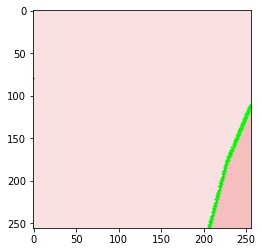

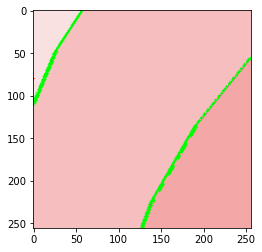

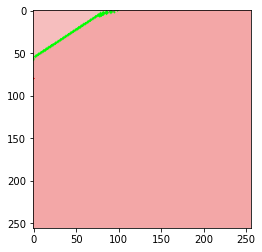

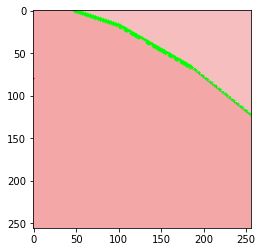

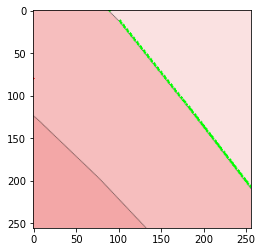

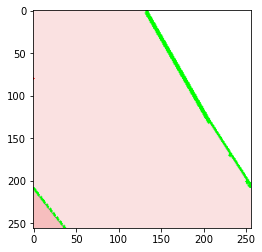

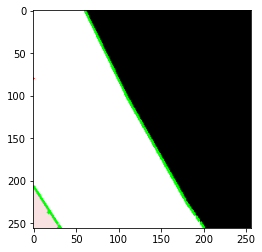

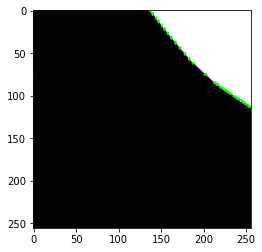

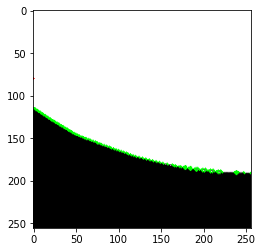

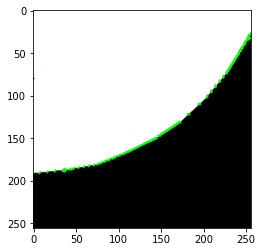

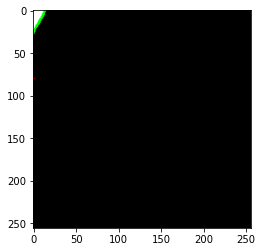

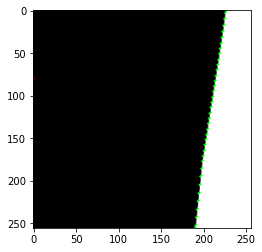

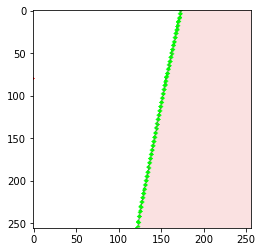

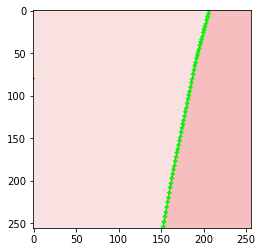

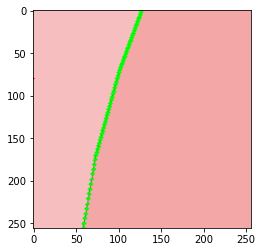

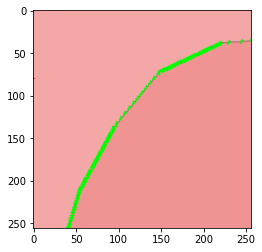

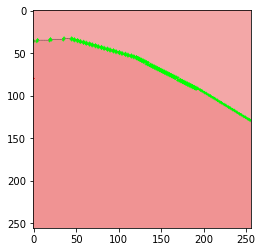

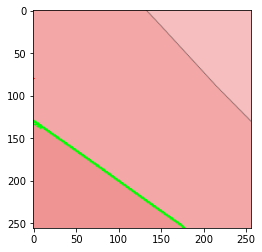

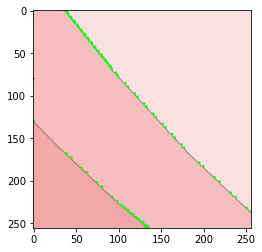

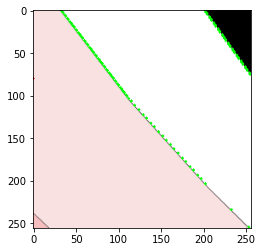

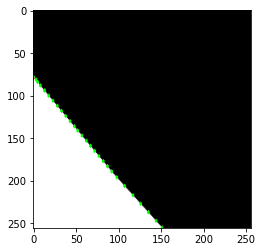

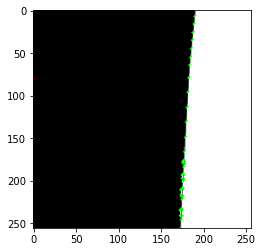

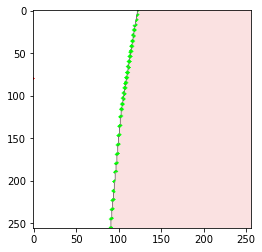

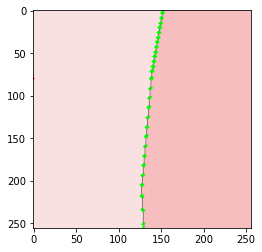

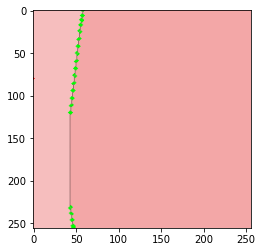

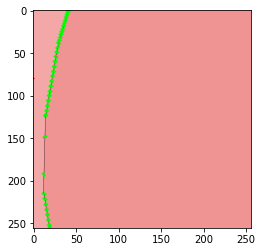

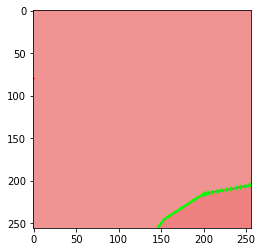

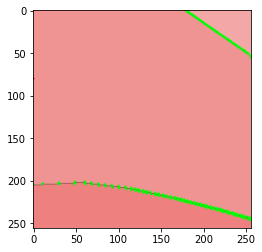

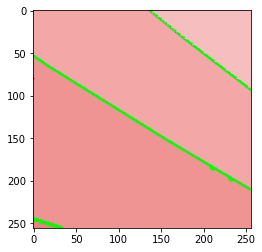

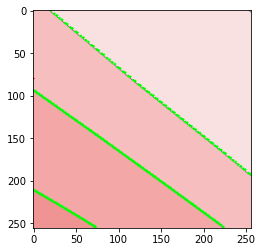

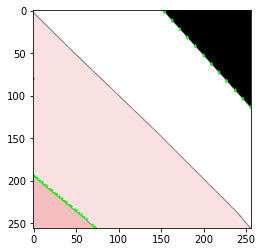

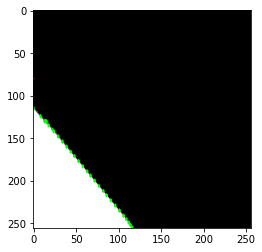

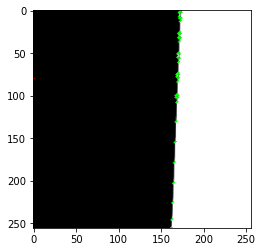

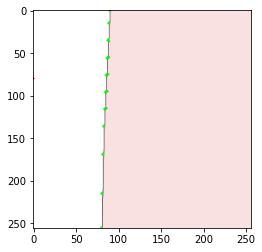

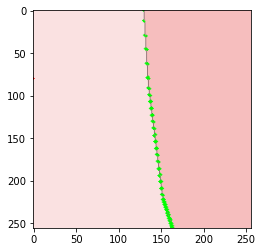

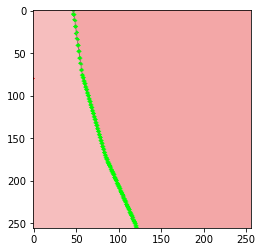

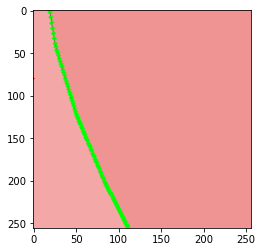

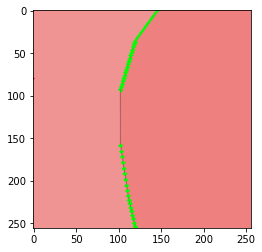

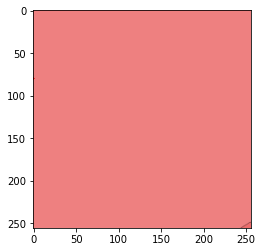

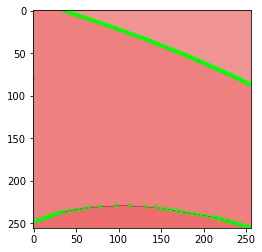

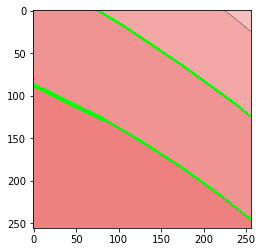

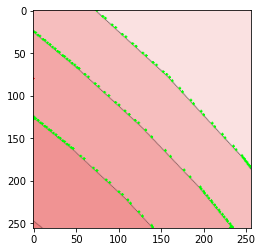

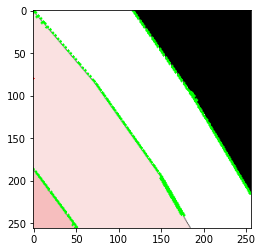

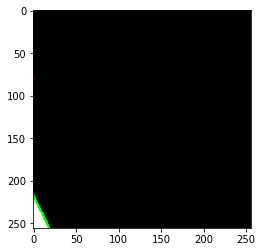

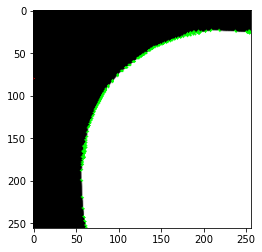

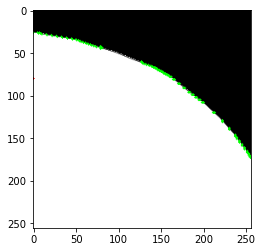

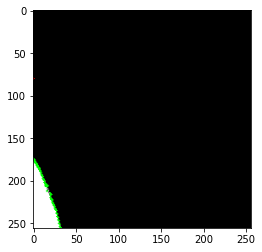

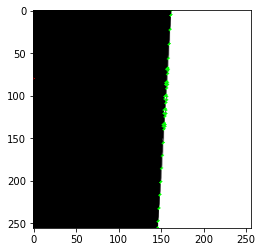

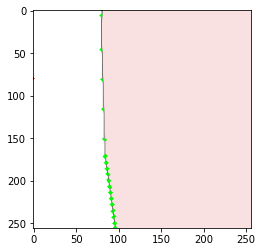

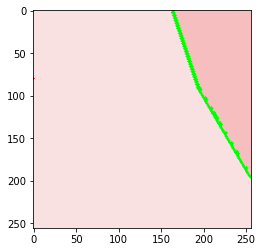

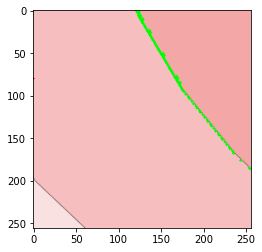

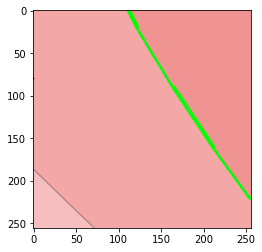

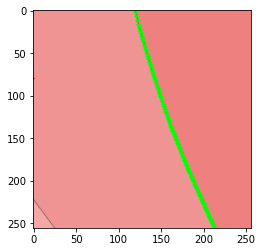

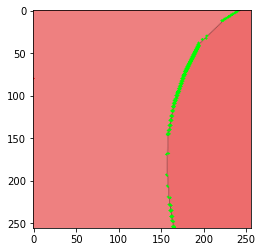

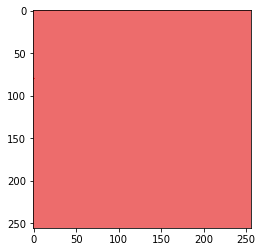

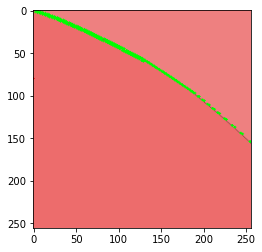

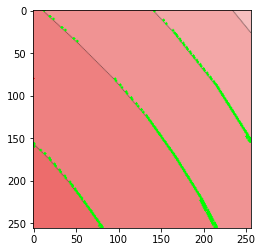

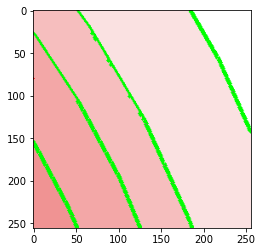

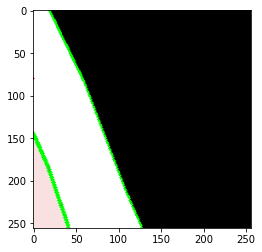

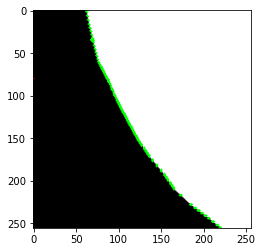

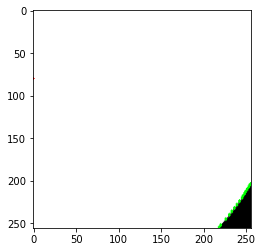

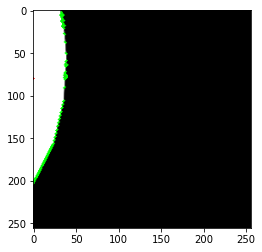

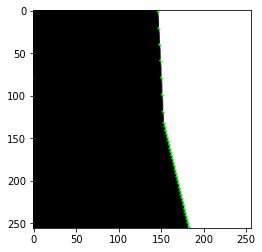

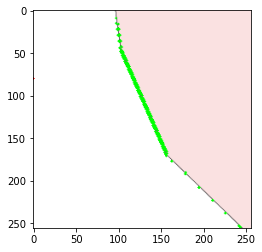

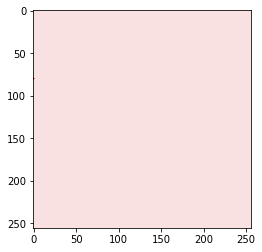

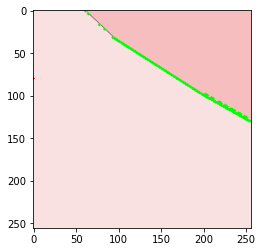

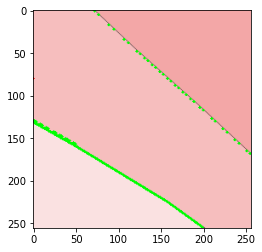

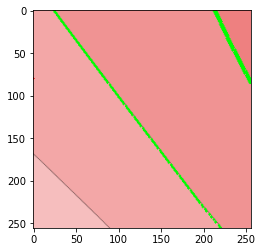

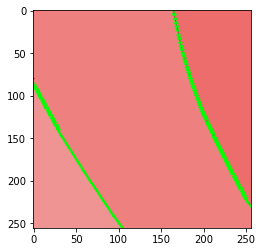

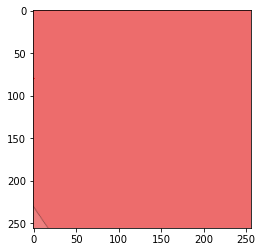

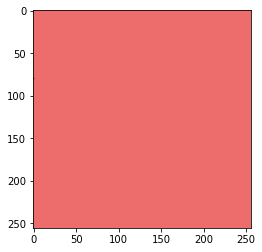

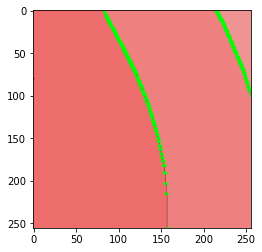

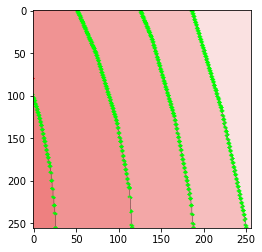

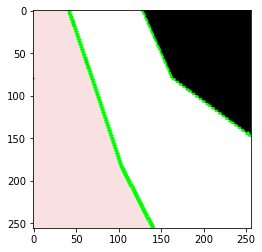

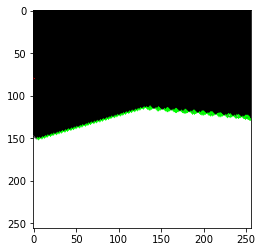

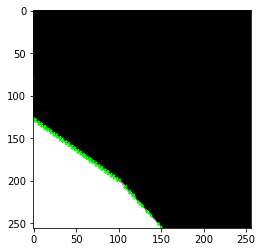

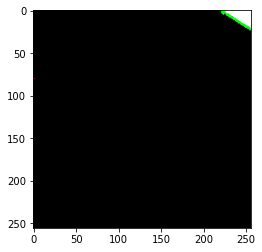

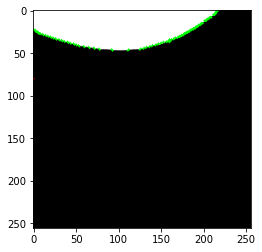

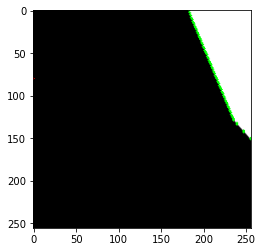

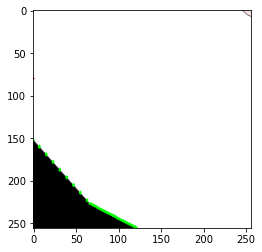

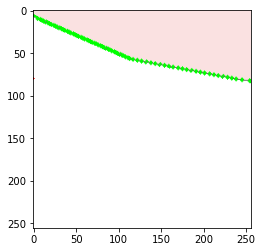

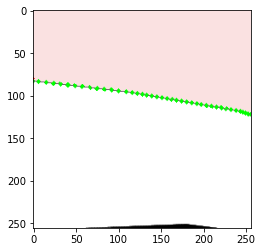

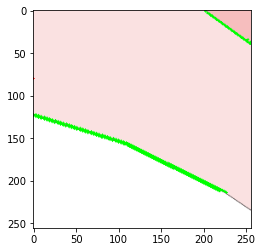

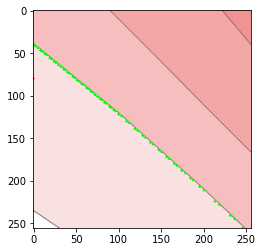

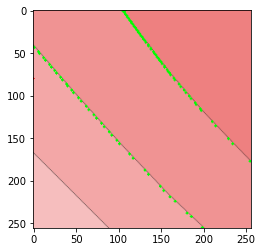

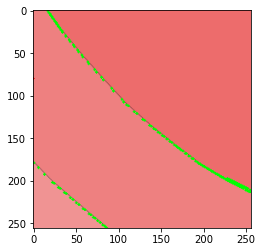

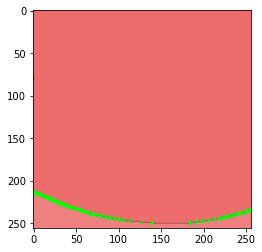

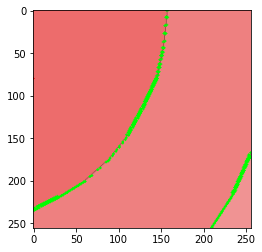

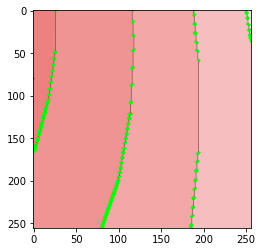

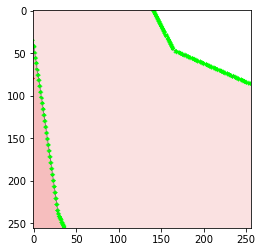

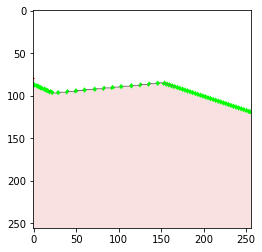

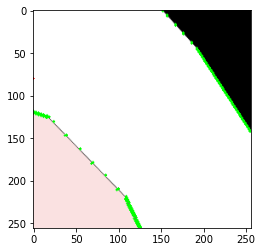

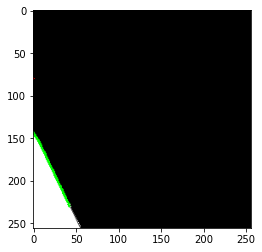

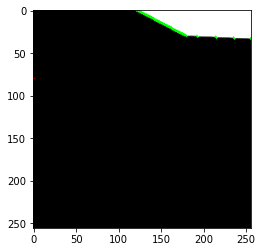

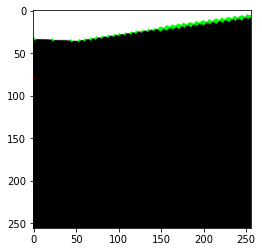

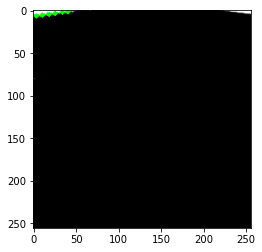

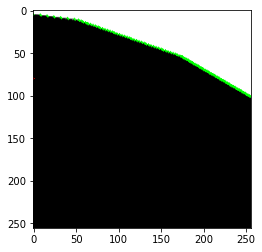

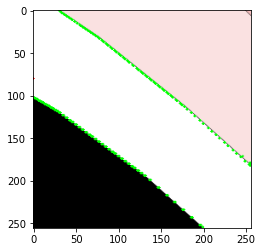

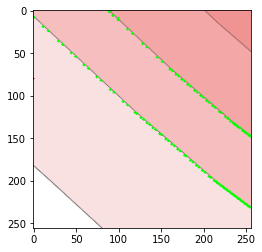

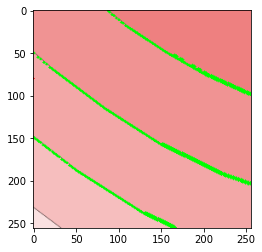

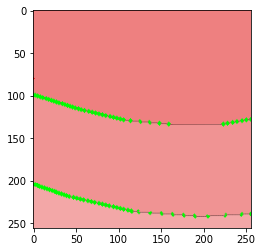

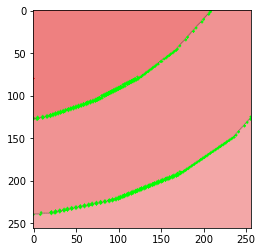

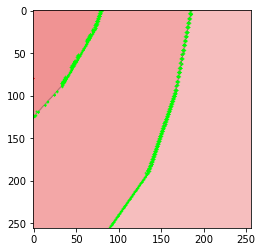

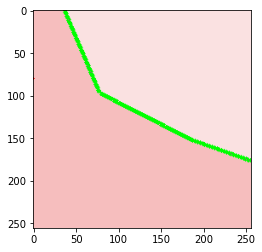

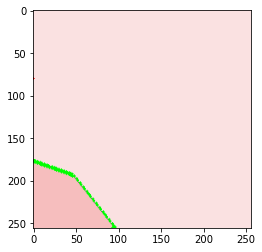

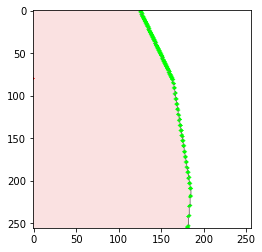

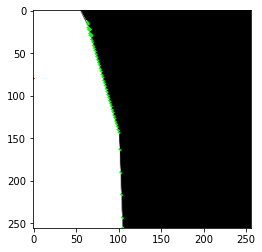

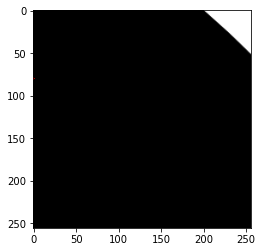

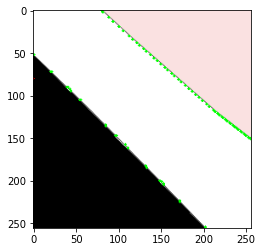

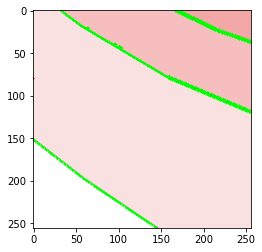

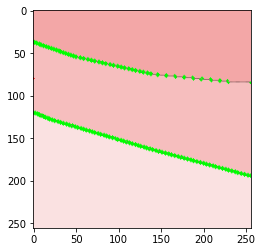

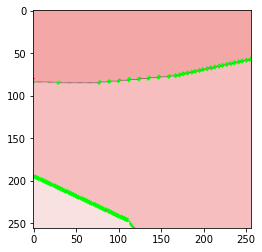

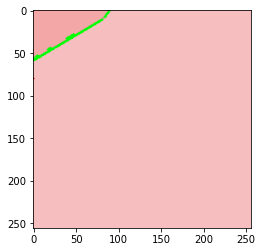

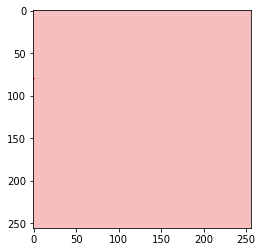

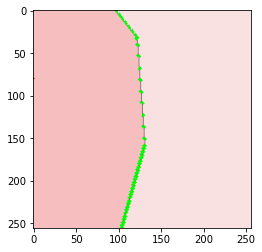

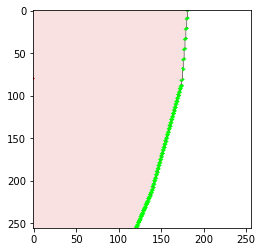

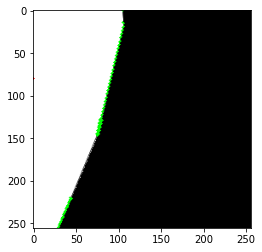

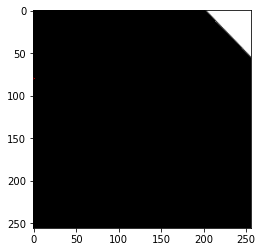

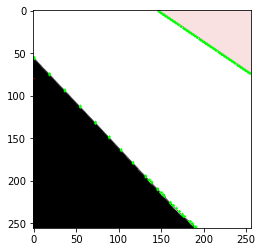

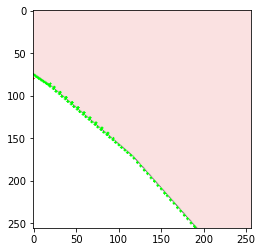

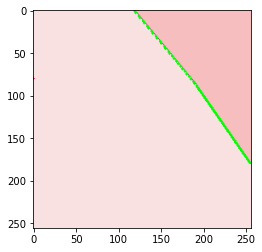

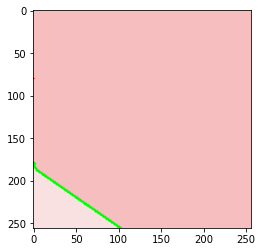

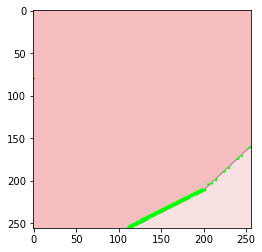

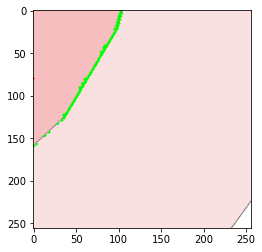

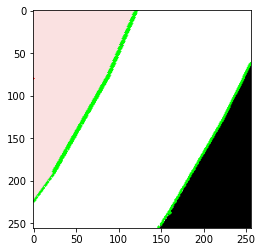

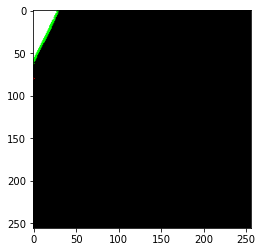

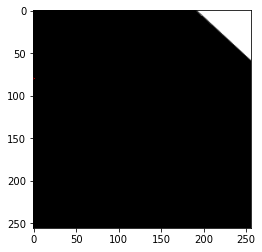

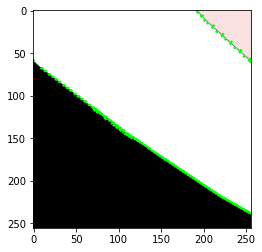

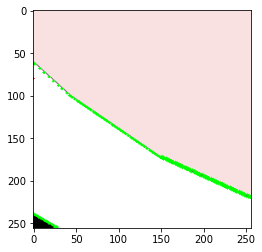

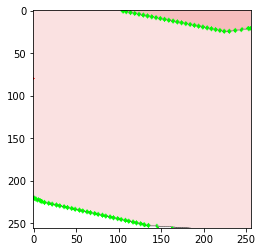

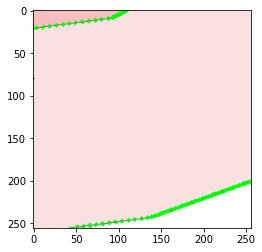

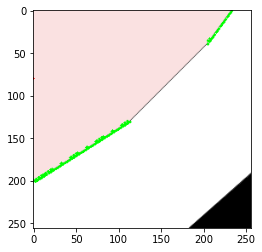

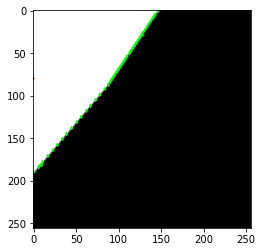

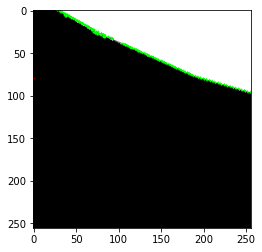

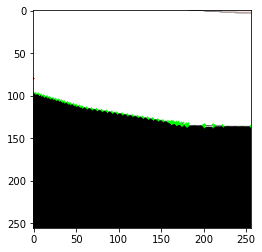

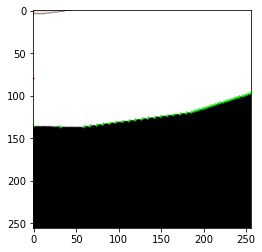

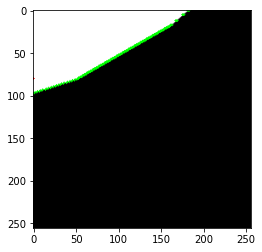

KeyboardInterrupt: 

In [24]:
# polygone_zone = {}
# for zone in zones_coord.keys():
#     i_max = max(zones_coord[zone][0][0],zones_coord[zone][1][0])
#     i_min = min(zones_coord[zone][0][0],zones_coord[zone][1][0])
#     j_max = max(zones_coord[zone][0][1],zones_coord[zone][1][1])
#     j_min = min(zones_coord[zone][0][1],zones_coord[zone][1][1])
#     for i in range(i_min,i_max+1):
#         for j in range(j_min,j_max+1):
#             if requests.get(f'https://static.satbeams.com/tiles/{zone}/7/{i}/{j}.png').status_code != 200:
#                 continue
zones_tiles_coord = {}
for zone in zones_coord.keys():
    print(zone)
    x,y,w,h = zones_coord[zone][0][0],zones_coord[zone][0][1],zones_coord[zone][1][0],zones_coord[zone][1][1]
    print(x,y,w,h)
    zones_tiles_coord[zone] = get_granica(zone,x-5,w+5,y-5,h+5) 

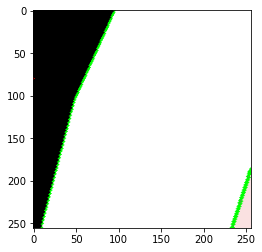

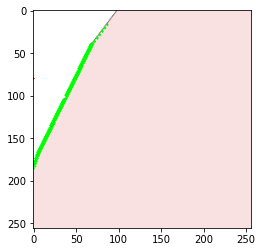

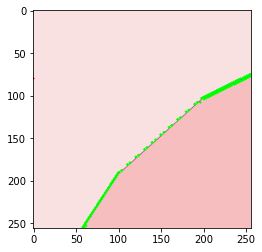

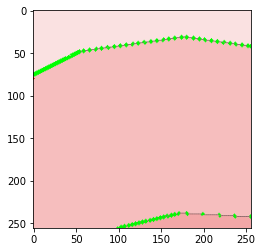

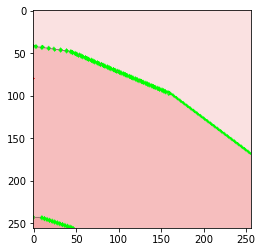

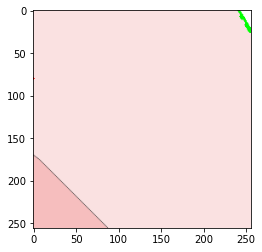

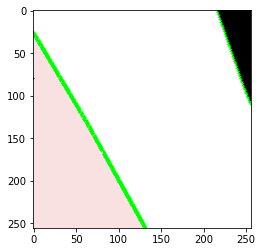

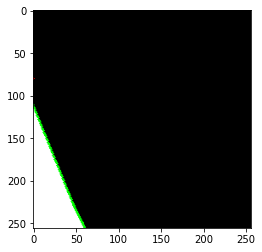

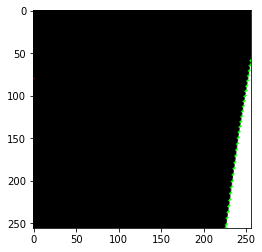

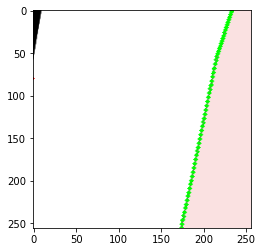

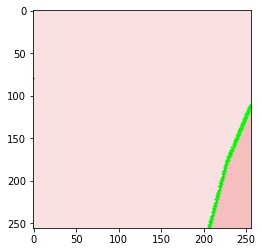

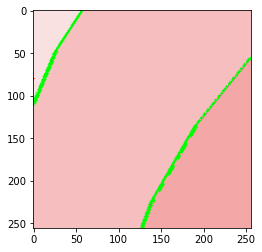

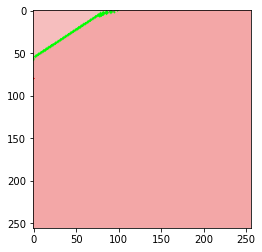

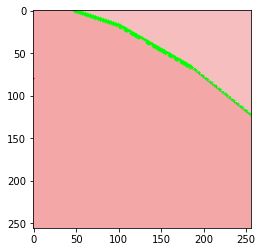

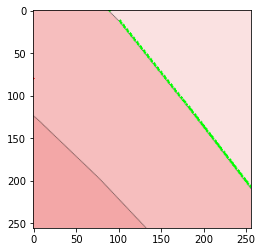

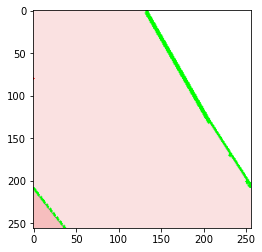

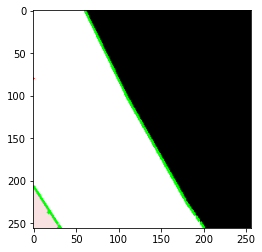

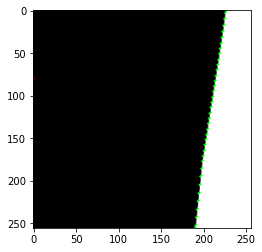

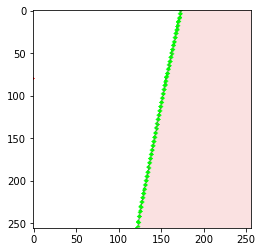

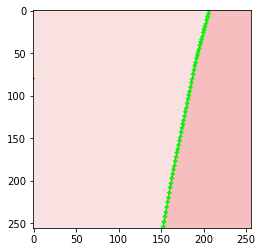

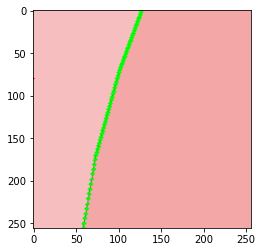

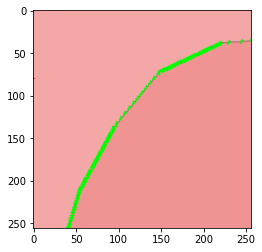

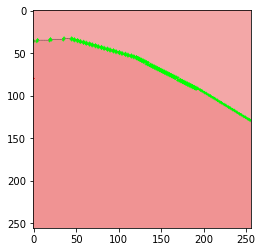

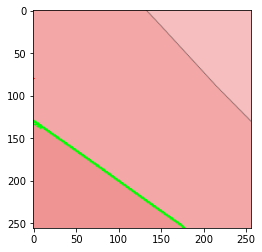

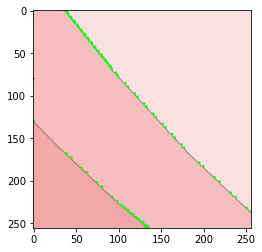

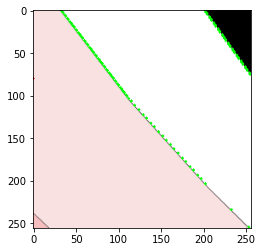

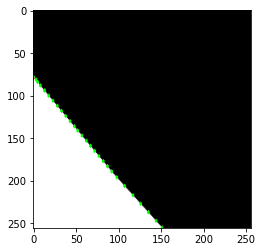

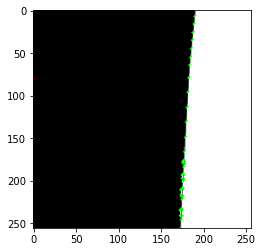

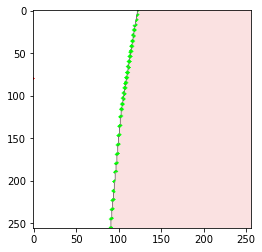

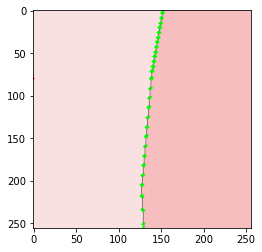

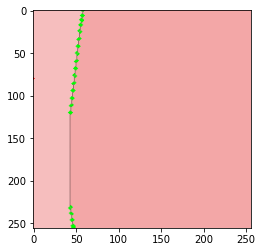

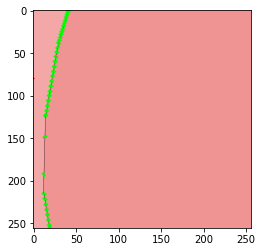

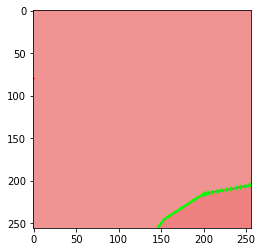

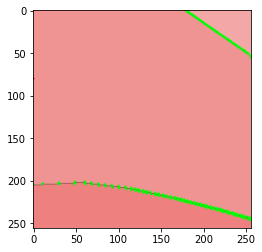

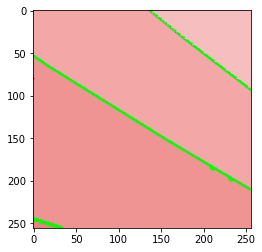

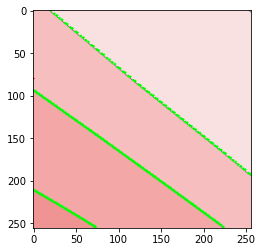

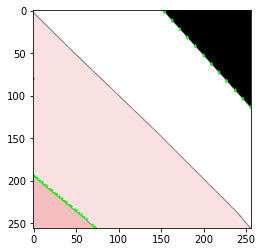

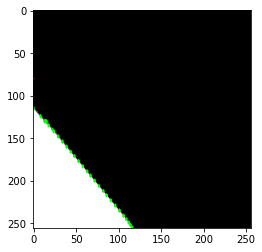

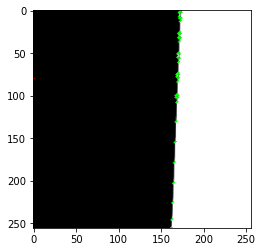

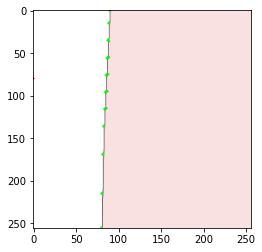

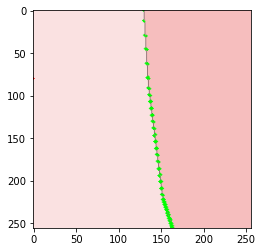

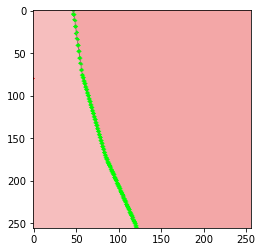

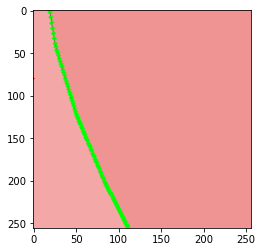

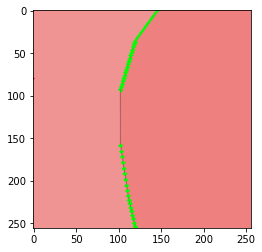

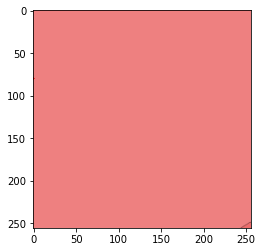

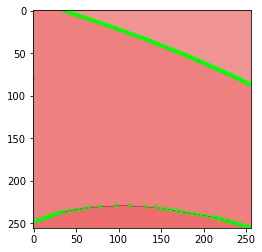

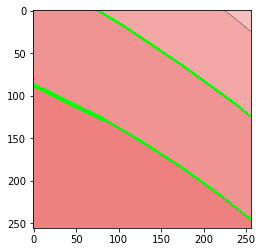

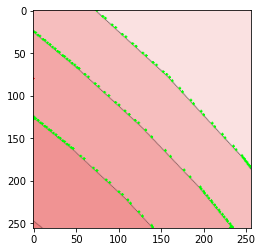

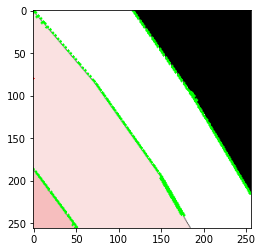

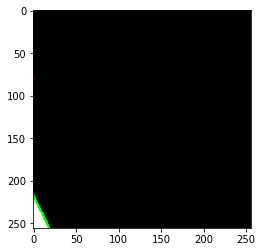

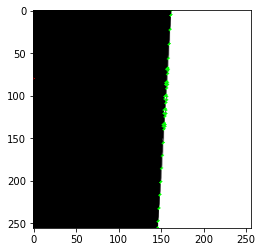

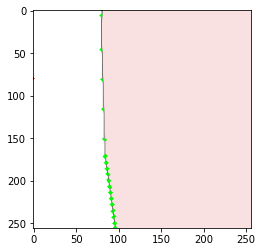

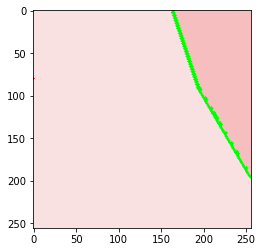

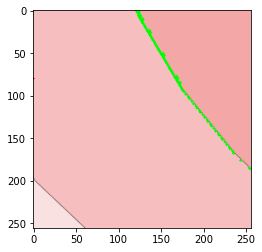

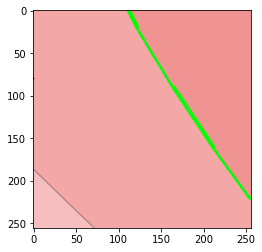

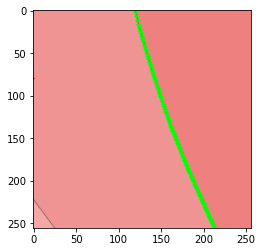

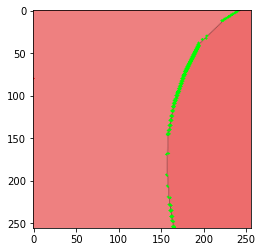

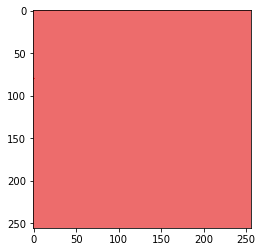

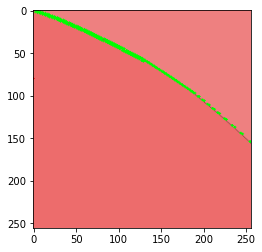

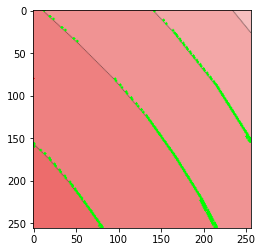

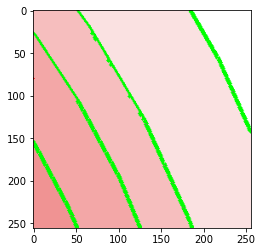

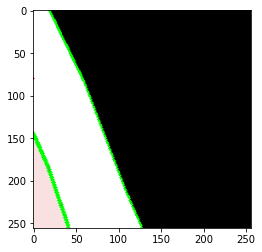

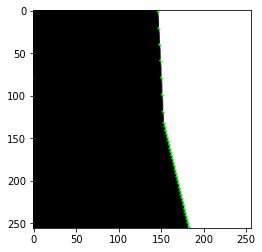

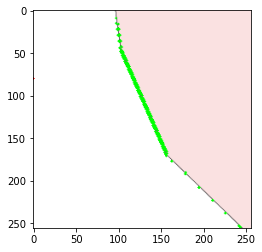

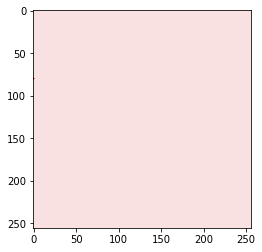

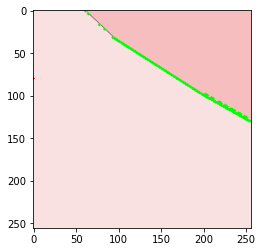

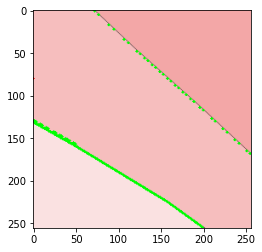

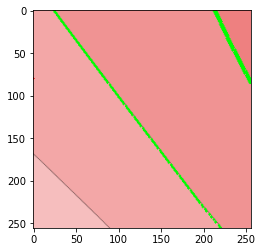

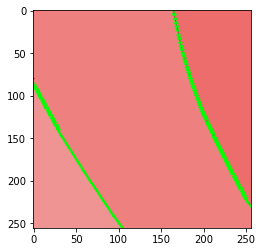

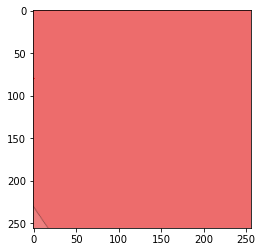

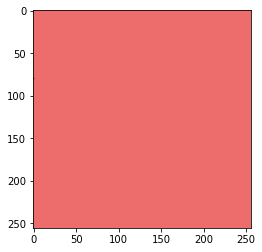

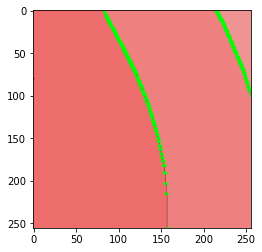

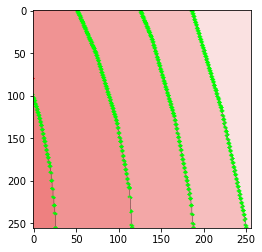

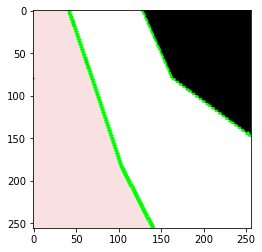

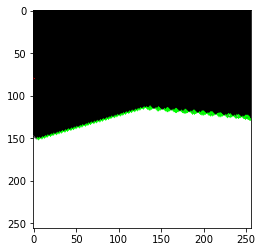

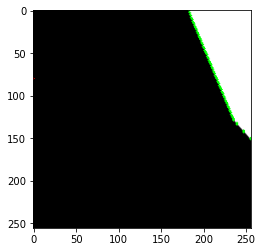

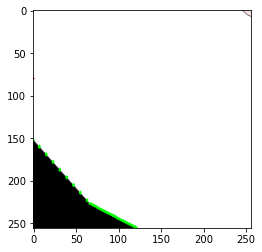

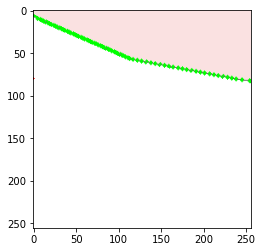

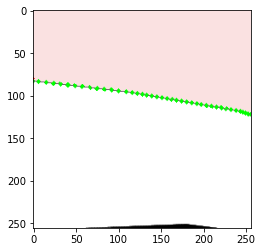

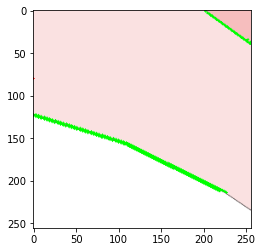

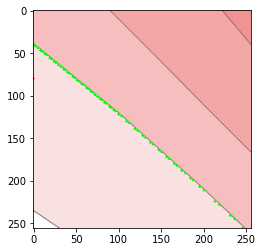

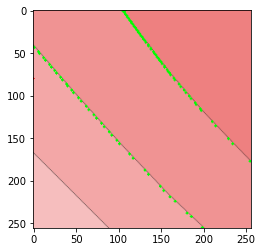

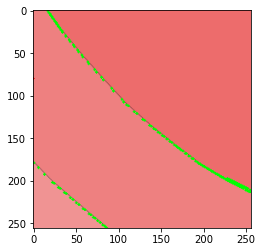

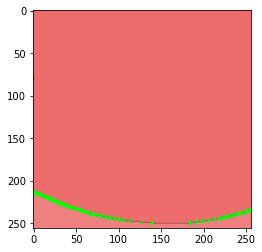

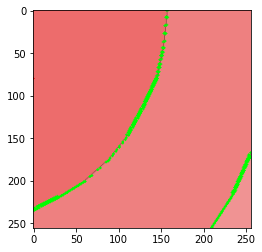

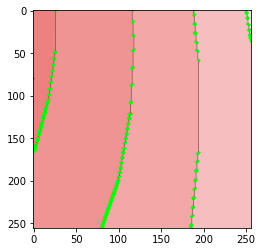

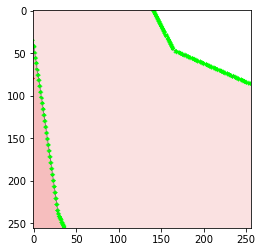

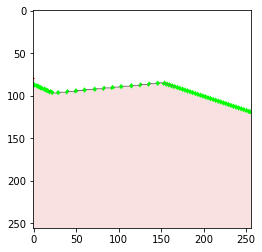

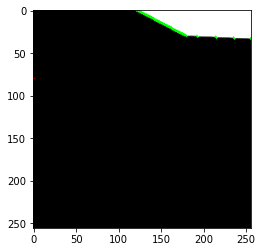

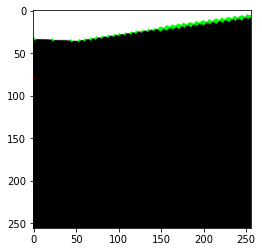

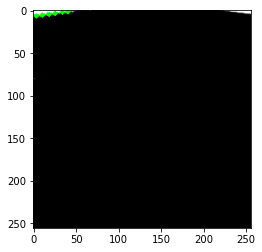

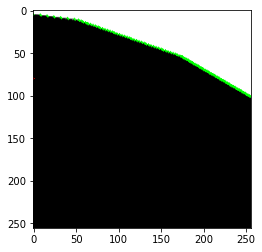

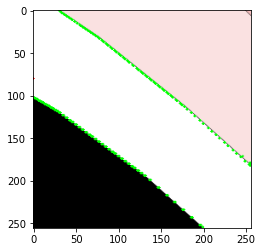

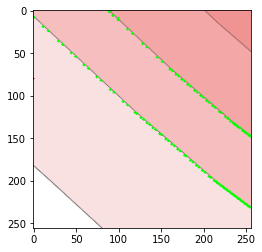

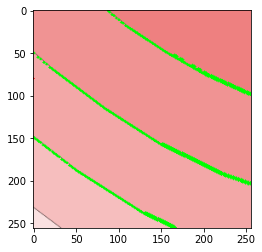

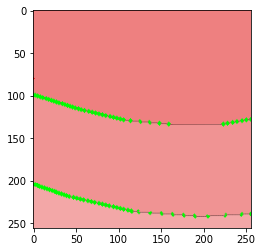

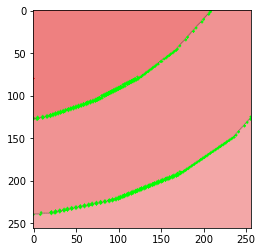

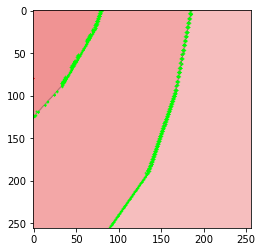

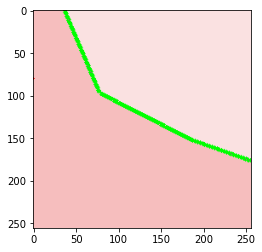

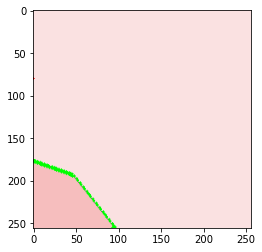

In [22]:
%matplotlib inline
# добавил 5 тайлов для погрешности
gr = get_granica('76W-Ku-M2DL',20,37,51,59)

In [23]:
# zones_tiles_coord
gr

{'26_51': {0: [[232, 255],
   [233, 251],
   [233, 254],
   [234, 248],
   [234, 250],
   [235, 245],
   [235, 247],
   [235, 252],
   [235, 255],
   [236, 242],
   [236, 244],
   [236, 249],
   [236, 251],
   [237, 239],
   [237, 241],
   [237, 246],
   [237, 248],
   [238, 236],
   [238, 238],
   [238, 243],
   [238, 245],
   [239, 233],
   [239, 235],
   [239, 240],
   [239, 242],
   [240, 230],
   [240, 232],
   [240, 237],
   [240, 239],
   [241, 226],
   [241, 229],
   [241, 234],
   [241, 236],
   [242, 223],
   [242, 225],
   [242, 231],
   [242, 233],
   [243, 220],
   [243, 222],
   [243, 228],
   [243, 230],
   [244, 217],
   [244, 219],
   [244, 225],
   [244, 227],
   [245, 214],
   [245, 216],
   [245, 221],
   [245, 224],
   [246, 211],
   [246, 213],
   [246, 218],
   [246, 220],
   [247, 208],
   [247, 210],
   [247, 215],
   [247, 217],
   [248, 205],
   [248, 207],
   [248, 212],
   [248, 214],
   [249, 202],
   [249, 204],
   [249, 209],
   [249, 211],
   [250, 199]

In [48]:
# mm = gr['28_54_0']
# mm
# len(gr['30_55'][0])
# gr['38_43'][0]
# zones_tiles_coord
# Пытаюсь объеденить одну линию по всем тайлам
def get_sides_for_line(zone):
#     print(list(zone.keys()))
    t_s = list(zone.keys())[0]
    p_s = list(zone[t_s].keys())[0]
    polygons = {}
    t_x,t_y = list(map(int,t_s.split('_')))
    start = zone[t_s][p_s]
    a = True
    cnt = 0
    polygons[cnt] = start
    while a == True:
        right_s = [sublist for sublist in start if 235 <= sublist[0] <= 255]
        down_s = [sublist for sublist in start if 235 <= sublist[1] <= 255]
        left_s = [sublist for sublist in start if 20 >= sublist[0] >= 0]
        up_s = [sublist for sublist in start if 20 >= sublist[1] >= 0]
        if left_s != [] and right_s != []:
            t_e_1 = str(t_x+1) + '_' + str(t_y)
            t_e_2 = str(t_x-1) + '_' + str(t_y)
            if t_e_1 in list(zone.keys()):
                for p in zone[t_e_1].keys():
                    left_e = [sublist for sublist in zone[t_e_1][p] if 20 >= sublist[0] >= 0]
                    if abs(left_e[-1][-1] - right_s[-1][0]) <= 20:
                        polygons[cnt].append(zone[t_e_1][p])
                        start = zone[t_e_1][p]
                        t_s = t_e_1
                        t_x += 1
                        break
            elif t_e_2 in list(zone.keys()):
                for p in zone[t_e_2].keys():
                    right_e = [sublist for sublist in zone[t_e_2][p] if 20 >= sublist[0] >= 0]
                    if abs(right_e[-1][0] - right_s[-1][-1]) <= 20:
                        polygons[cnt].append(zone[t_e_2][p])
                        start = zone[t_e_2][p]
                        t_s = t_e_2
                        t_x -= 1
                        break
                
            left_e = [sublist for sublist in zone[t_e_1][p_e_1] if 20 >= sublist[0] >= 0]
            right_e = [sublist for sublist in zone[t_e_2][p_e_2] if 235 <= sublist[0] <= 255]
            if right_s[-1][-1] - left_e
    return right_s,down_s,left_s,up_s
#     right = [sublist for sublist in zones_tiles_coord[z][n][c] if sublist[0] == 255]
#     down = [sublist for sublist in zones_tiles_coord[z][n][c] if sublist[1] == 255]
#     left = [sublist for sublist in zones_tiles_coord[z][n][c] if sublist[0] == 0]
#     up = [sublist for sublist in zones_tiles_coord[z][n][c] if sublist[1] == 0]
# for z in zones_tiles_coord.keys():
#     print(z)
#     for n in zones_tiles_coord[z]:
#         for c in zones_tiles_coord[z][n]:
#             print(c)
#             right = [sublist for sublist in zones_tiles_coord[z][n][c] if sublist[0] == 255]
#             down = [sublist for sublist in zones_tiles_coord[z][n][c] if sublist[1] == 255]
#             left = [sublist for sublist in zones_tiles_coord[z][n][c] if sublist[0] == 0]
#             up = [sublist for sublist in zones_tiles_coord[z][n][c] if sublist[1] == 0]
#             print('right')|
#             print(right)
#             print('down')
#             print(down)
#             print('left')
#             print(left)
#             print('up')
#             print(up)

In [49]:
get_sides_for_line(gr)

([[240, 230],
  [240, 232],
  [240, 237],
  [240, 239],
  [241, 226],
  [241, 229],
  [241, 234],
  [241, 236],
  [242, 223],
  [242, 225],
  [242, 231],
  [242, 233],
  [243, 220],
  [243, 222],
  [243, 228],
  [243, 230],
  [244, 217],
  [244, 219],
  [244, 225],
  [244, 227],
  [245, 214],
  [245, 216],
  [245, 221],
  [245, 224],
  [246, 211],
  [246, 213],
  [246, 218],
  [246, 220],
  [247, 208],
  [247, 210],
  [247, 215],
  [247, 217],
  [248, 205],
  [248, 207],
  [248, 212],
  [248, 214],
  [249, 202],
  [249, 204],
  [249, 209],
  [249, 211],
  [250, 199],
  [250, 201],
  [250, 206],
  [250, 208],
  [251, 195],
  [251, 198],
  [251, 203],
  [251, 205],
  [252, 192],
  [252, 194],
  [252, 200],
  [252, 202],
  [253, 189],
  [253, 190],
  [253, 191],
  [253, 192],
  [253, 197],
  [253, 199],
  [254, 188],
  [254, 189],
  [254, 193],
  [254, 193],
  [254, 196],
  [255, 186],
  [255, 187],
  [255, 187],
  [255, 189],
  [255, 191],
  [255, 192],
  [255, 192]],
 [[232, 255],
  [23

In [21]:
# mm

[(-101.25, 2.9595918826659116, 7),
 (-100.458984375, 2.9595918826659116, 7),
 (-99.66796875, 2.9595918826659116, 7),
 (-98.876953125, 2.536793042285069, 7),
 (-98.0859375, 2.536793042285069, 7),
 (-98.0859375, 2.536793042285069, 7),
 (-97.294921875, 2.536793042285069, 7),
 (-96.50390625, 2.113994201904223, 7),
 (-95.712890625, 2.113994201904223, 7),
 (-95.712890625, 2.113994201904223, 7),
 (-94.921875, 2.113994201904223, 7),
 (-94.130859375, 1.691195361523377, 7),
 (-93.33984375, 1.691195361523377, 7),
 (-93.33984375, 1.691195361523377, 7),
 (-92.548828125, 1.691195361523377, 7),
 (-91.7578125, 1.2683965211425345, 7),
 (-90.966796875, 1.2683965211425345, 7),
 (-90.966796875, 1.2683965211425345, 7),
 (-90.17578125, 1.2683965211425345, 7),
 (-89.384765625, 0.8455976807616885, 7),
 (-88.59375, 0.8455976807616885, 7),
 (-88.59375, 0.8455976807616885, 7),
 (-87.802734375, 0.8455976807616885, 7),
 (-87.01171875, 0.42279884038084603, 7),
 (-86.220703125, 0.42279884038084603, 7),
 (-86.2207031

In [22]:
mmm = gr['27_54_0']
mmm

[[46, 0],
 [48, 0],
 [49, 0],
 [49, 1],
 [50, 1],
 [51, 1],
 [51, 1],
 [52, 2],
 [53, 3],
 [54, 2],
 [54, 3],
 [54, 3],
 [55, 4],
 [55, 4],
 [57, 4],
 [57, 4],
 [58, 5],
 [58, 5],
 [59, 5],
 [60, 5],
 [60, 6],
 [61, 6],
 [62, 6],
 [62, 6],
 [63, 7],
 [63, 7],
 [64, 7],
 [64, 7],
 [65, 8],
 [65, 8],
 [66, 8],
 [66, 8],
 [67, 9],
 [67, 9],
 [68, 9],
 [68, 9],
 [69, 10],
 [69, 10],
 [71, 10],
 [71, 10],
 [72, 11],
 [72, 11],
 [73, 11],
 [73, 11],
 [74, 12],
 [75, 12],
 [75, 13],
 [76, 13],
 [77, 13],
 [78, 13],
 [78, 14],
 [79, 14],
 [79, 14],
 [80, 14],
 [81, 16],
 [82, 16],
 [82, 16],
 [83, 16],
 [83, 17],
 [84, 17],
 [84, 17],
 [85, 17],
 [85, 18],
 [86, 18],
 [86, 18],
 [87, 18],
 [87, 19],
 [88, 19],
 [88, 19],
 [89, 19],
 [90, 21],
 [91, 21],
 [91, 21],
 [92, 21],
 [92, 22],
 [93, 22],
 [93, 22],
 [94, 22],
 [94, 23],
 [95, 23],
 [95, 23],
 [96, 23],
 [96, 24],
 [97, 24],
 [97, 24],
 [98, 24],
 [99, 26],
 [100, 26],
 [100, 26],
 [101, 26],
 [101, 27],
 [102, 27],
 [102, 27],
 [103, 

In [23]:
for l in range(len(mmm)):
    mmm[l] = pic_coord_to_lat_lon(mmm[l][0],mmm[l][1],7,xtile=27,ytile=54)

In [24]:
mmm

[(-66.6650390625, 27.059125784374054, 7),
 (-65.0390625, 27.059125784374054, 7),
 (-64.22607421875, 27.059125784374054, 7),
 (-64.22607421875, 26.847726364183632, 7),
 (-63.4130859375, 26.847726364183632, 7),
 (-62.60009765625, 26.847726364183632, 7),
 (-62.60009765625, 26.847726364183632, 7),
 (-61.787109375, 26.636326943993208, 7),
 (-60.97412109375, 26.424927523802786, 7),
 (-60.1611328125, 26.636326943993208, 7),
 (-60.1611328125, 26.424927523802786, 7),
 (-60.1611328125, 26.424927523802786, 7),
 (-59.34814453125, 26.213528103612365, 7),
 (-59.34814453125, 26.213528103612365, 7),
 (-57.72216796875, 26.213528103612365, 7),
 (-57.72216796875, 26.213528103612365, 7),
 (-56.9091796875, 26.002128683421944, 7),
 (-56.9091796875, 26.002128683421944, 7),
 (-56.09619140625, 26.002128683421944, 7),
 (-55.283203125, 26.002128683421944, 7),
 (-55.283203125, 25.79072926323152, 7),
 (-54.47021484375, 25.79072926323152, 7),
 (-53.6572265625, 25.79072926323152, 7),
 (-53.6572265625, 25.79072926323

In [25]:
num2deg(27,54,7)

(-104.0625, 27.059125784374054)

In [26]:
num2deg(28,54,7)

(-101.25, 27.059125784374054)

In [83]:
[1,2] - [1,3]

TypeError: unsupported operand type(s) for -: 'list' and 'list'